In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import functions.nominal_rigidity_network as nominal_rigidity_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 2: One Occupation Per Sector

Suppose there is one type of labor specific to each sector, in other words that $\mathcal{O}=J$. We calibrate our model to mathc BEA input-output tables, and treat the residual, the part of production not accounted for by intermediate inputs, as the labor elasticity. 

In [2]:
A_spec = 1
data_dir = '../data/clean/'
dfTau = pd.read_csv(data_dir + 'tau_2021.csv').sort_values(by=['short_names'])
dfA      = pd.read_csv(data_dir + f'A{A_spec}.csv')
sectors = dfA['short_names']
dfDemand  = pd.read_csv(data_dir + 'demand_tab.csv')
dfLshare = pd.read_csv(data_dir + 'labor_tab.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'uvh_annual_updated.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['Year', 'short_names'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['Year'] == 2021]
dfMatching_params = pd.read_csv(data_dir + 'matching_param_estimates.csv')
shares = pd.read_csv(data_dir + 'energy_capital_shares.csv')
sector_names = list(dfA['short_names']) + ['Agg Y']
occupation_names = list(dfA['short_names'])

In [3]:
shares

,short_names,Capital share,Energy share
0,accom,0.221841,0.023295
1,const,0.097000,0.024000
2,dur,0.271000,0.008000
3,edhealth,0.126015,0.011191
4,fin,0.330830,0.035048
5,gov,0.000000,0.000000
6,info,0.377000,0.004000
7,mining,0.524000,0.029000
8,nondur,0.280069,0.022101
9,other,0.070000,0.010000


In [4]:
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
# rescale based on energy shares
rescaler = np.matrix(1 - shares['Capital share'] - shares['Energy share'])
J = Omega.shape[0]
Omega = np.multiply(Omega, (np.repeat(rescaler, J)).reshape(J, J))
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
O = J

epsN = np.diag(np.array(dfLshare[f'labor_elasticity{A_spec}'], dtype='float64'))
epsN = np.multiply(epsN, rescaler)
epsD = np.array(dfDemand['demand_elasticity']).reshape((J,1))
epsK = np.matrix(shares[['Capital share', 'Energy share']])

K = epsK.shape[1]

θ = dfLabor_market_yearly['Tightness'] 
curlyQ = -np.diag(dfMatching_params['unemployment_elasticity'])
curlyF =  np.eye(J) + curlyQ
curlyT = np.diag(dfTau['Tau'])
curlyL = np.eye(J)

We assume Cobb-Douglas production and preferences.

In [5]:
dlog_lam = np.zeros((J, 1))
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
dlog_epsK = np.zeros_like(epsK)

## Response to Energy Shocks

Here, we plot the response to energy shocks under the following wage assumptions: Hulten, 0.5MP, Real rigidity, nominal ridigity, and dampening.

In [6]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O, 1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01 
num = 3
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
PriceAssumption = ['Hulten', '0.5MP', 'Rigid Real', 'Rigid Nominal', 'Dampening']
sectorY_vec = np.zeros((J+1,len(PriceAssumption)))
occT_vec = np.zeros((O, len(PriceAssumption)))
occU_vec = np.zeros((O, len(PriceAssumption)))
p_vec = np.zeros((J, len(PriceAssumption)))

In [7]:
epsWs = {'Hulten': multi_occupation_network.WageElasticityFunc(gamma_A=1, gamma_H=1, gamma_K=1, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK),
        '0.5MP': multi_occupation_network.WageElasticityFuncMP(0.5,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Rigid Real': multi_occupation_network.WageElasticityFuncMP(0,  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL),
        'Dampening': multi_occupation_network.WageElasticityFunc(gamma_A=1.5, gamma_H=1.5, gamma_K=1.5, Psi=Psi, curlyL=curlyL, epsN=epsN, epsK=epsK)}
dlog_Ws = {}
for i in epsWs.keys():
    epsW_A, epsW_H, epsW_K = epsWs[i]
    dlog_Ws[i] = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    

In [8]:
for i, a in enumerate(PriceAssumption):
    if a == 'Rigid Nominal':
        dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
        dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
    else:
        dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_Ws[a], dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
        dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
        dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
        dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_Ws[a], dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    p_vec[:, i] = dlog_p.flatten()
    occT_vec[:, i] = dlog_theta.flatten()
    occU_vec[:, i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()

In [9]:
sectorY_vec.shape

(14, 5)

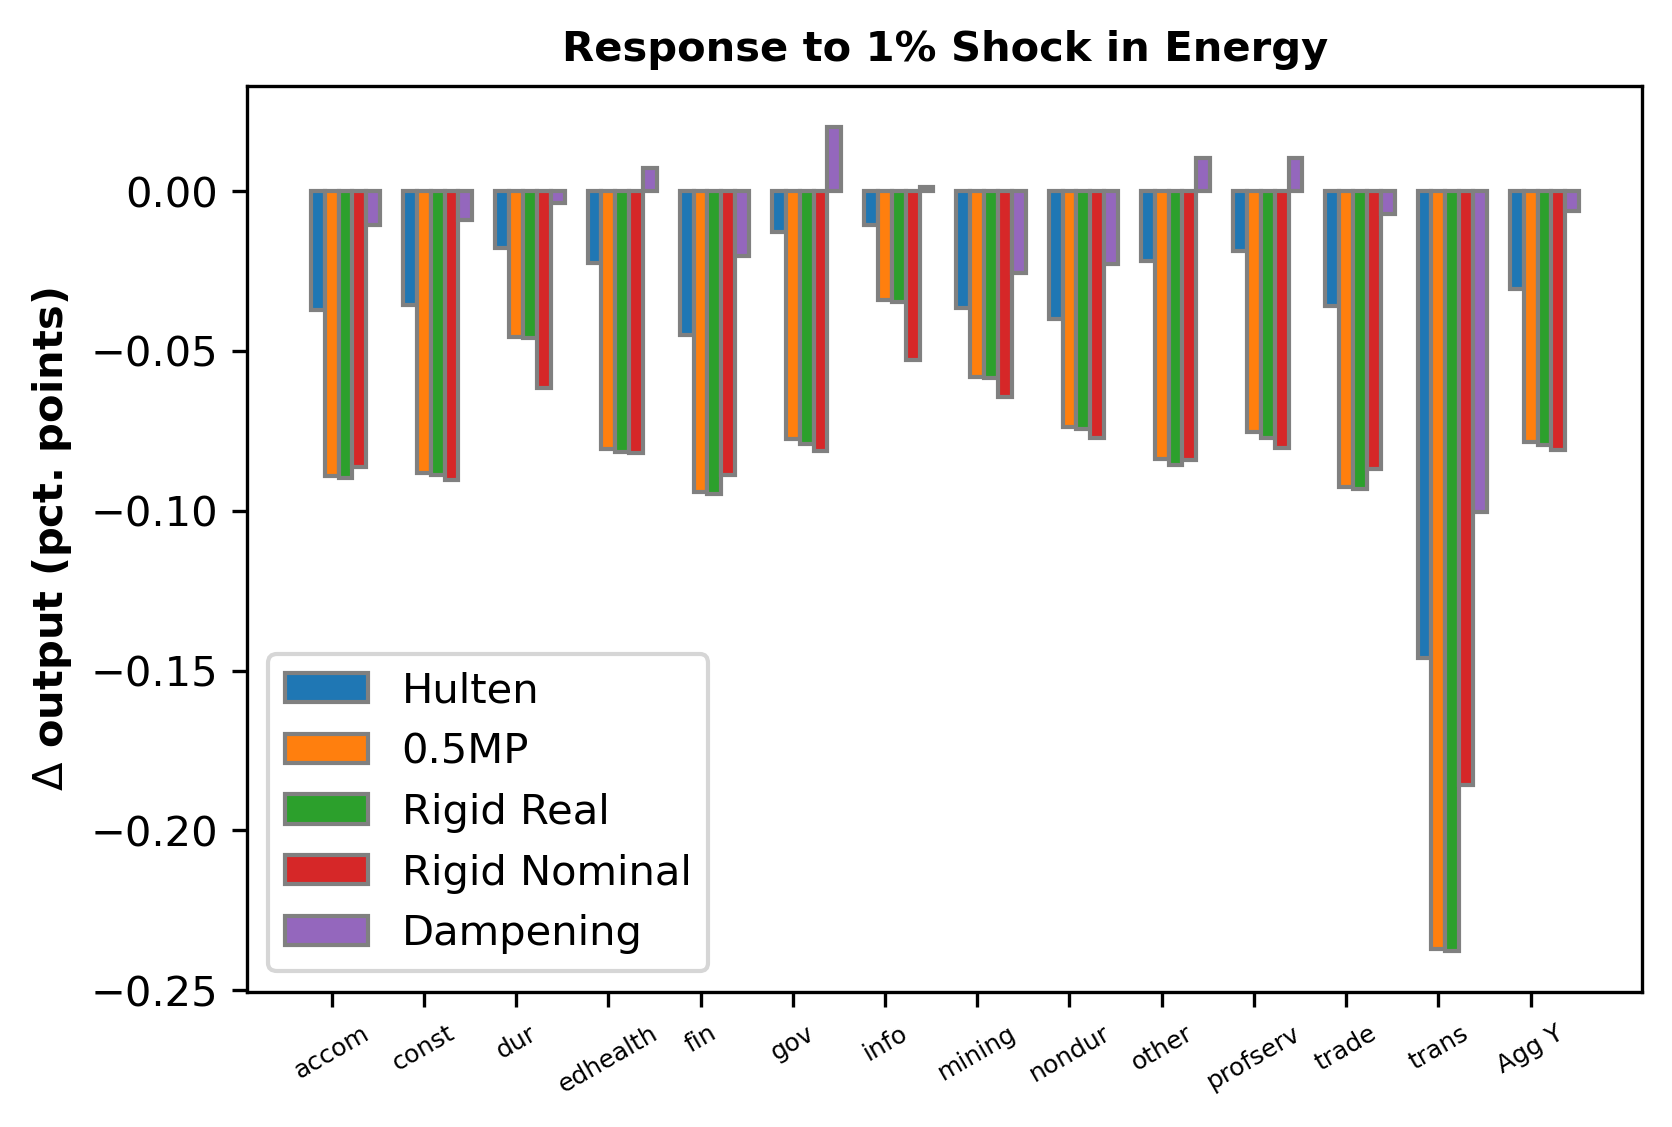

In [10]:
title = f'Response to 1% Shock in Energy'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockY_calib2.png'
labels = PriceAssumption
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

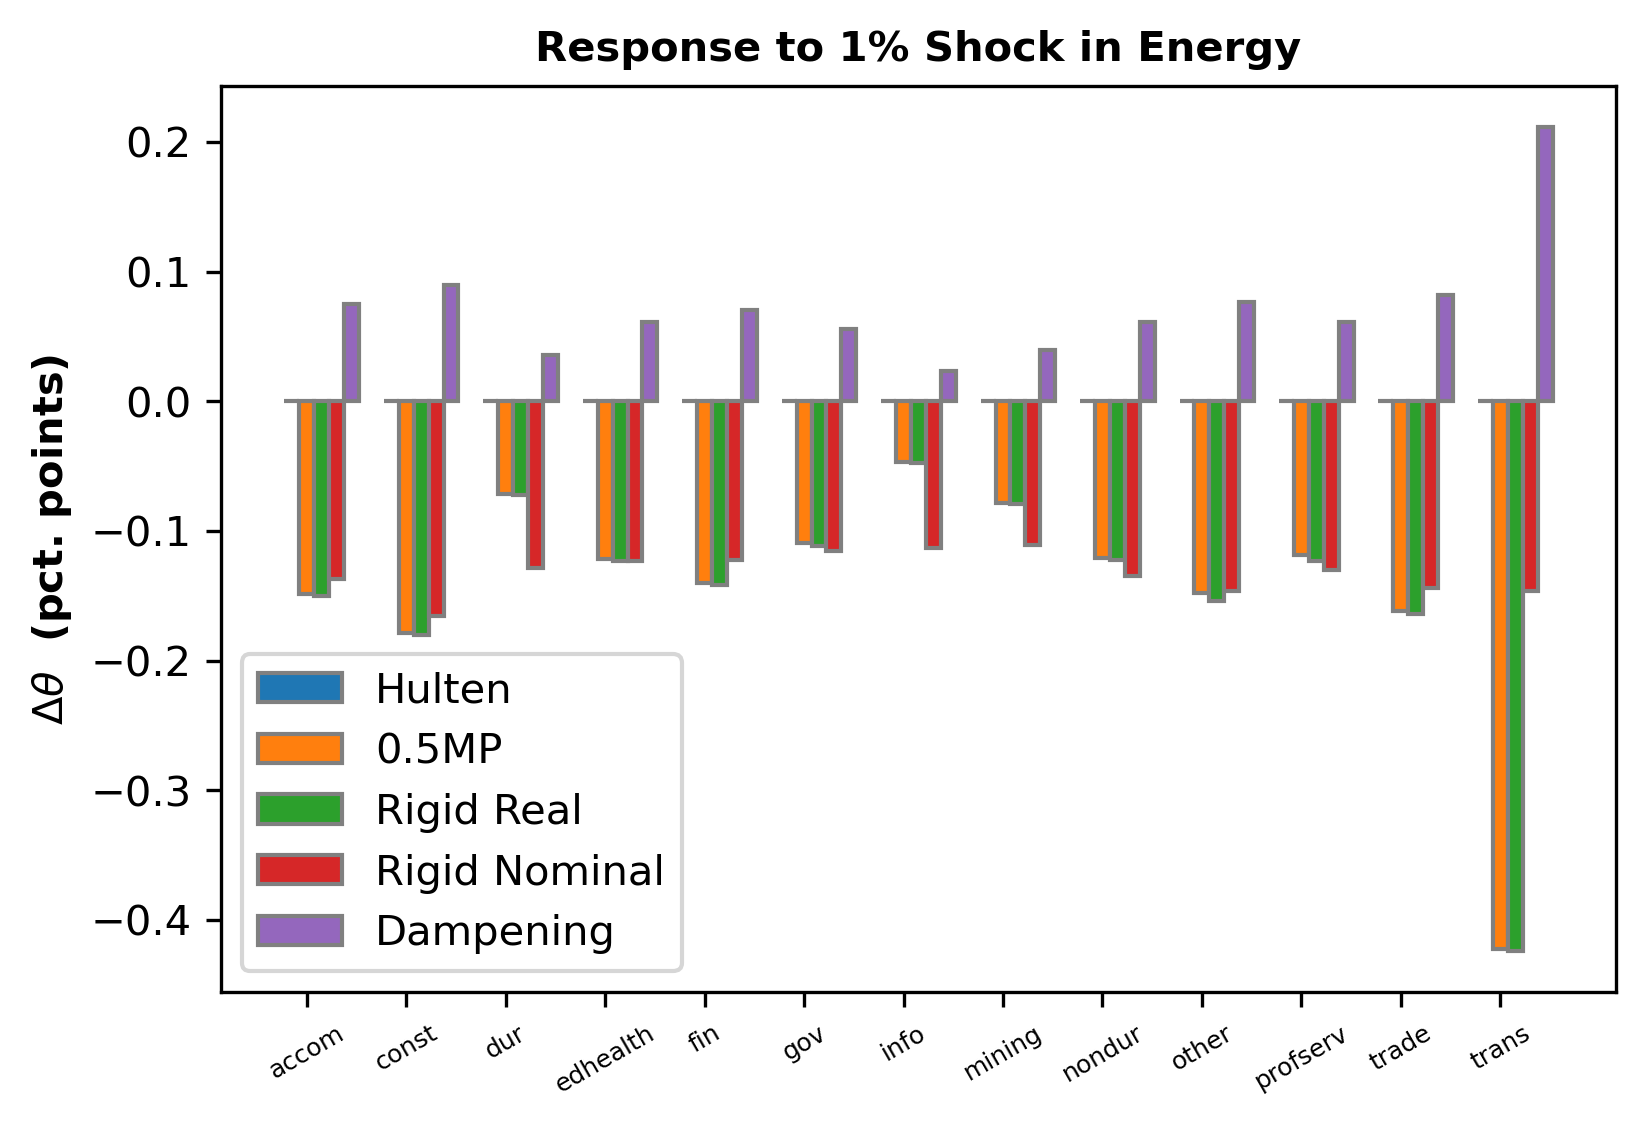

In [11]:
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockT_calib2.png'
labels = PriceAssumption
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

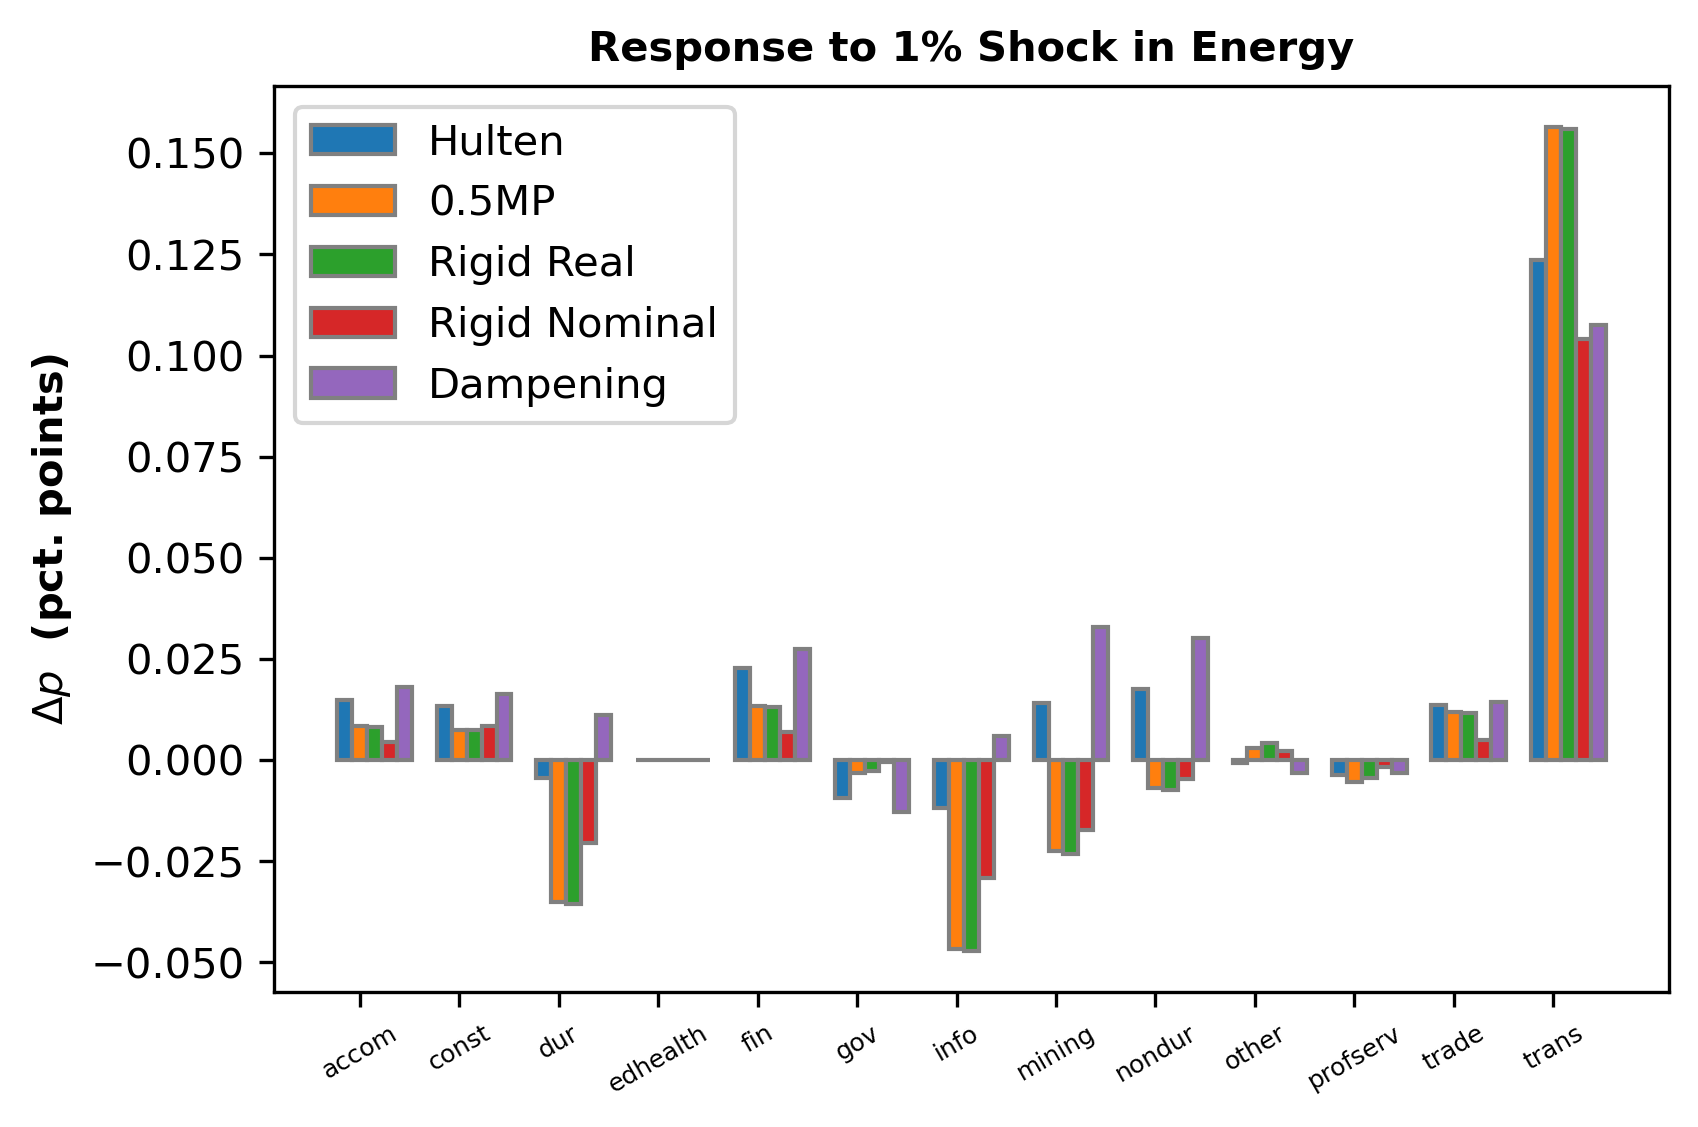

In [12]:
xlab = ''
ylab = '$\Delta p$  (pct. points)'
save_path = f'../output/figures/energy_A{A_spec}_KshockP_calib2.png'
labels = PriceAssumption
bar_plot(100*p_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.15, dpi=300)

## Wage changes proportional to marginal product of labor


In [13]:
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K, 1))
dlog_K[1] = -0.01
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)
#epsW_A = np.zeros((O,J))
gamma = 0.5
epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma, Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
epsW_K

matrix([[9.60270987e-04, 9.57436963e-05],
        [2.24776311e-03, 2.21739270e-04],
        [3.67722593e-03, 1.77951997e-04],
        [2.23830794e-03, 2.01286546e-04],
        [3.50824990e-03, 3.70320480e-04],
        [3.99583502e-03, 3.49515303e-04],
        [4.55530796e-03, 1.62946925e-04],
        [1.70423477e-03, 1.05868066e-04],
        [4.03714931e-03, 3.25693907e-04],
        [1.20953392e-02, 1.17085497e-03],
        [1.03103758e-02, 8.85011940e-04],
        [2.11112515e-03, 2.19871412e-04],
        [5.74639978e-04, 1.80961351e-04]])

In [14]:
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
dlog_wR

matrix([[-9.57436963e-07],
        [-2.21739270e-06],
        [-1.77951997e-06],
        [-2.01286546e-06],
        [-3.70320480e-06],
        [-3.49515303e-06],
        [-1.62946925e-06],
        [-1.05868066e-06],
        [-3.25693907e-06],
        [-1.17085497e-05],
        [-8.85011940e-06],
        [-2.19871412e-06],
        [-1.80961351e-06]])

In [15]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
dlog_theta

matrix([[-0.00148817],
        [-0.00178284],
        [-0.00071379],
        [-0.00121211],
        [-0.00139855],
        [-0.00108928],
        [-0.00046617],
        [-0.00078655],
        [-0.0012078 ],
        [-0.00147641],
        [-0.00118427],
        [-0.00161919],
        [-0.00422528]])

In [16]:
num=0
dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
dlog_p

matrix([[0.        ],
        [0.00076972],
        [0.00034494],
        [0.0006809 ],
        [0.00082708],
        [0.00065453],
        [0.00022277],
        [0.00047254],
        [0.00062901],
        [0.00071261],
        [0.00062365],
        [0.00080825],
        [0.00225648]])

In [17]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
dlog_y

matrix([[-0.00089213],
        [-0.00088204],
        [-0.00045545],
        [-0.00080653],
        [-0.00094159],
        [-0.0007755 ],
        [-0.00033964],
        [-0.00058132],
        [-0.00073874],
        [-0.00083631],
        [-0.00075263],
        [-0.00092502],
        [-0.00237146]])

In [18]:
sectors

0        accom
1        const
2          dur
3     edhealth
4          fin
5          gov
6         info
7       mining
8       nondur
9        other
10    profserv
11       trade
12       trans
Name: short_names, dtype: object

In [19]:
# Setting which sectors to shock, and getting the full name of the sector. 
dlog_A = np.zeros((J, 1))
dlog_A[2] = -0.01
dlog_H = np.zeros((O, 1))
dlog_H[0] = -0.01
dlog_K = np.zeros((K, 1))
#dlog_K[1] = -0.01
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)

gamma = np.array([0.5, 0.999999999])
sectorY_vec = np.zeros((J+1, 2))
sectorP_vec = np.zeros((J, 2))
occT_vec = np.zeros((O, 2))
occU_vec = np.zeros((O, 2))
for i in range(2):
    epsW_A, epsW_H, epsW_K = multi_occupation_network.WageElasticityFuncMP(gamma[i],  Psi, epsN, epsK, curlyF, curlyQ, curlyT, curlyL)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, dlog_K, epsW_A, epsW_H, epsW_K)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_K, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN, epsK)
    occT_vec[:, i] = dlog_theta.flatten()
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
    occU_vec[:,i] = multi_occupation_network.UnemploymentFunc(multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF), dlog_H).flatten()
    num = 3
    dlog_r = multi_occupation_network.rFunc(dlog_y, dlog_K, num)
    dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_r, dlog_wR, dlog_theta, Psi, curlyQ, epsN, epsK, curlyT, curlyL, num=num)
    sectorP_vec[:, i] = dlog_p.flatten()

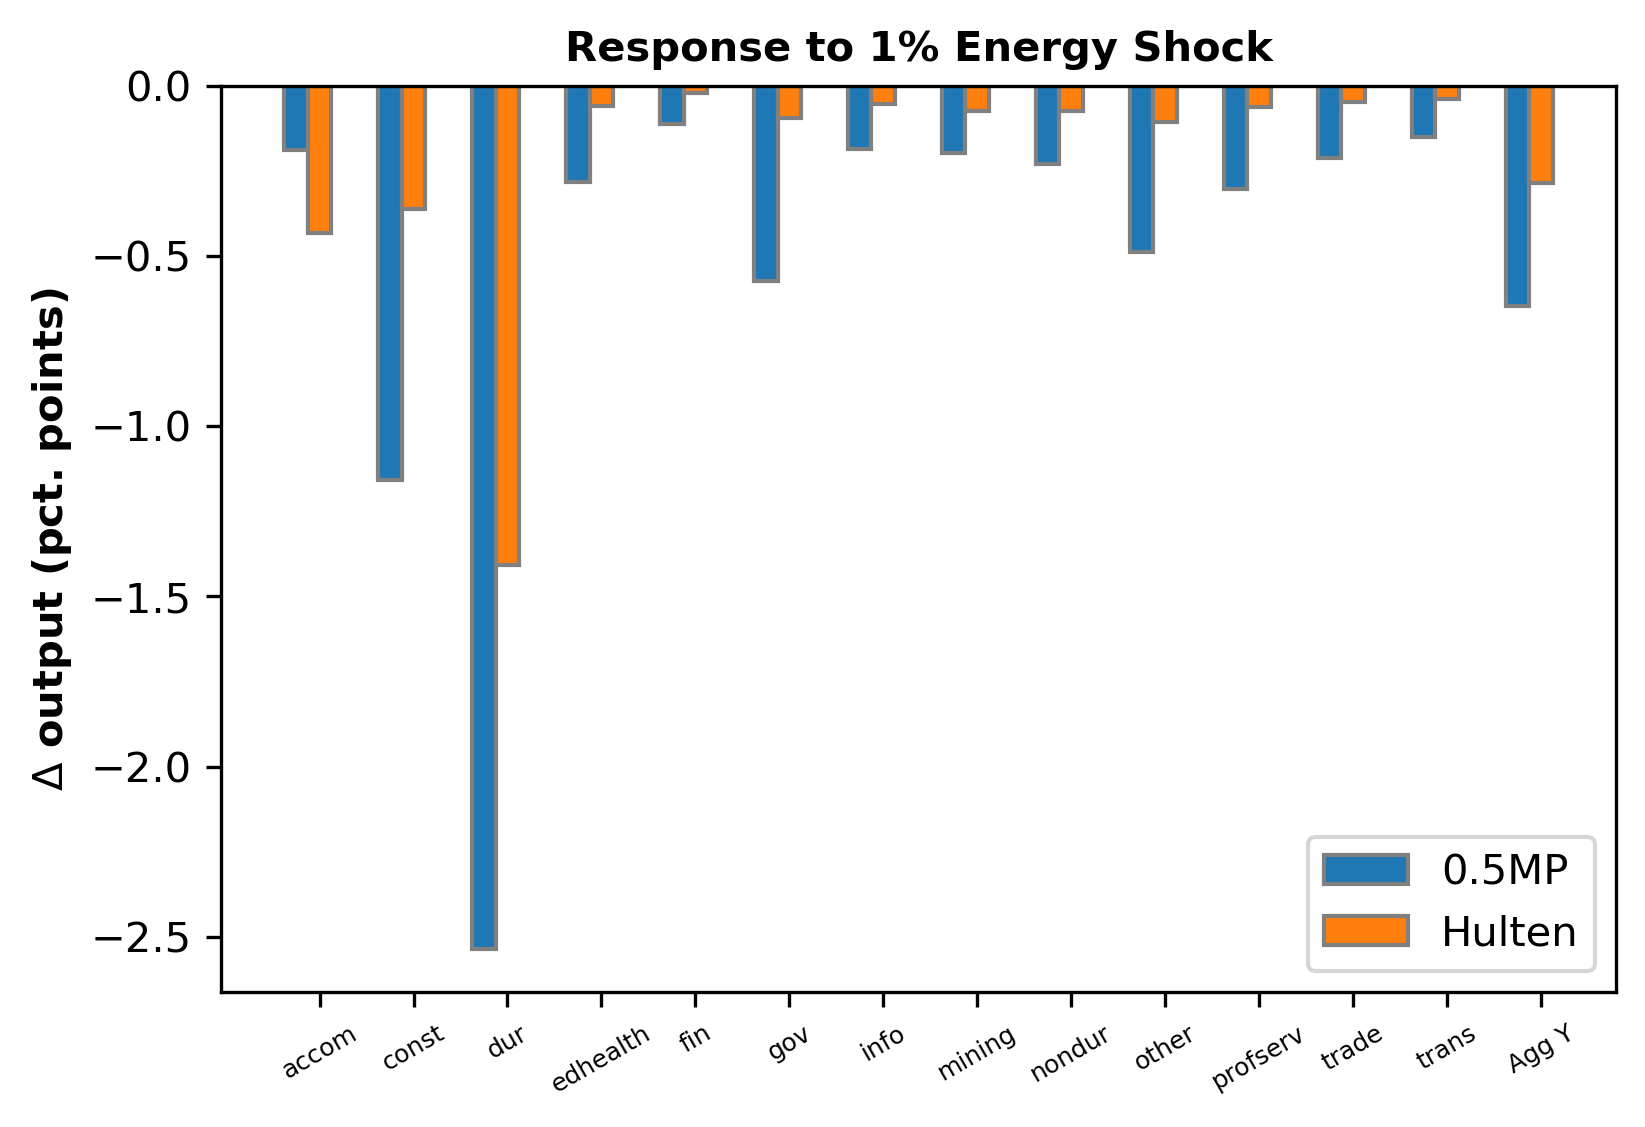

In [20]:
sector_names = list(dfA['short_names']) + ['Agg Y']
title = f'Response to 1% Energy Shock'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = f'../output/figures/A{A_spec}_EshockY_MP_calib2.png'
labels = ['0.5MP', 'Hulten']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

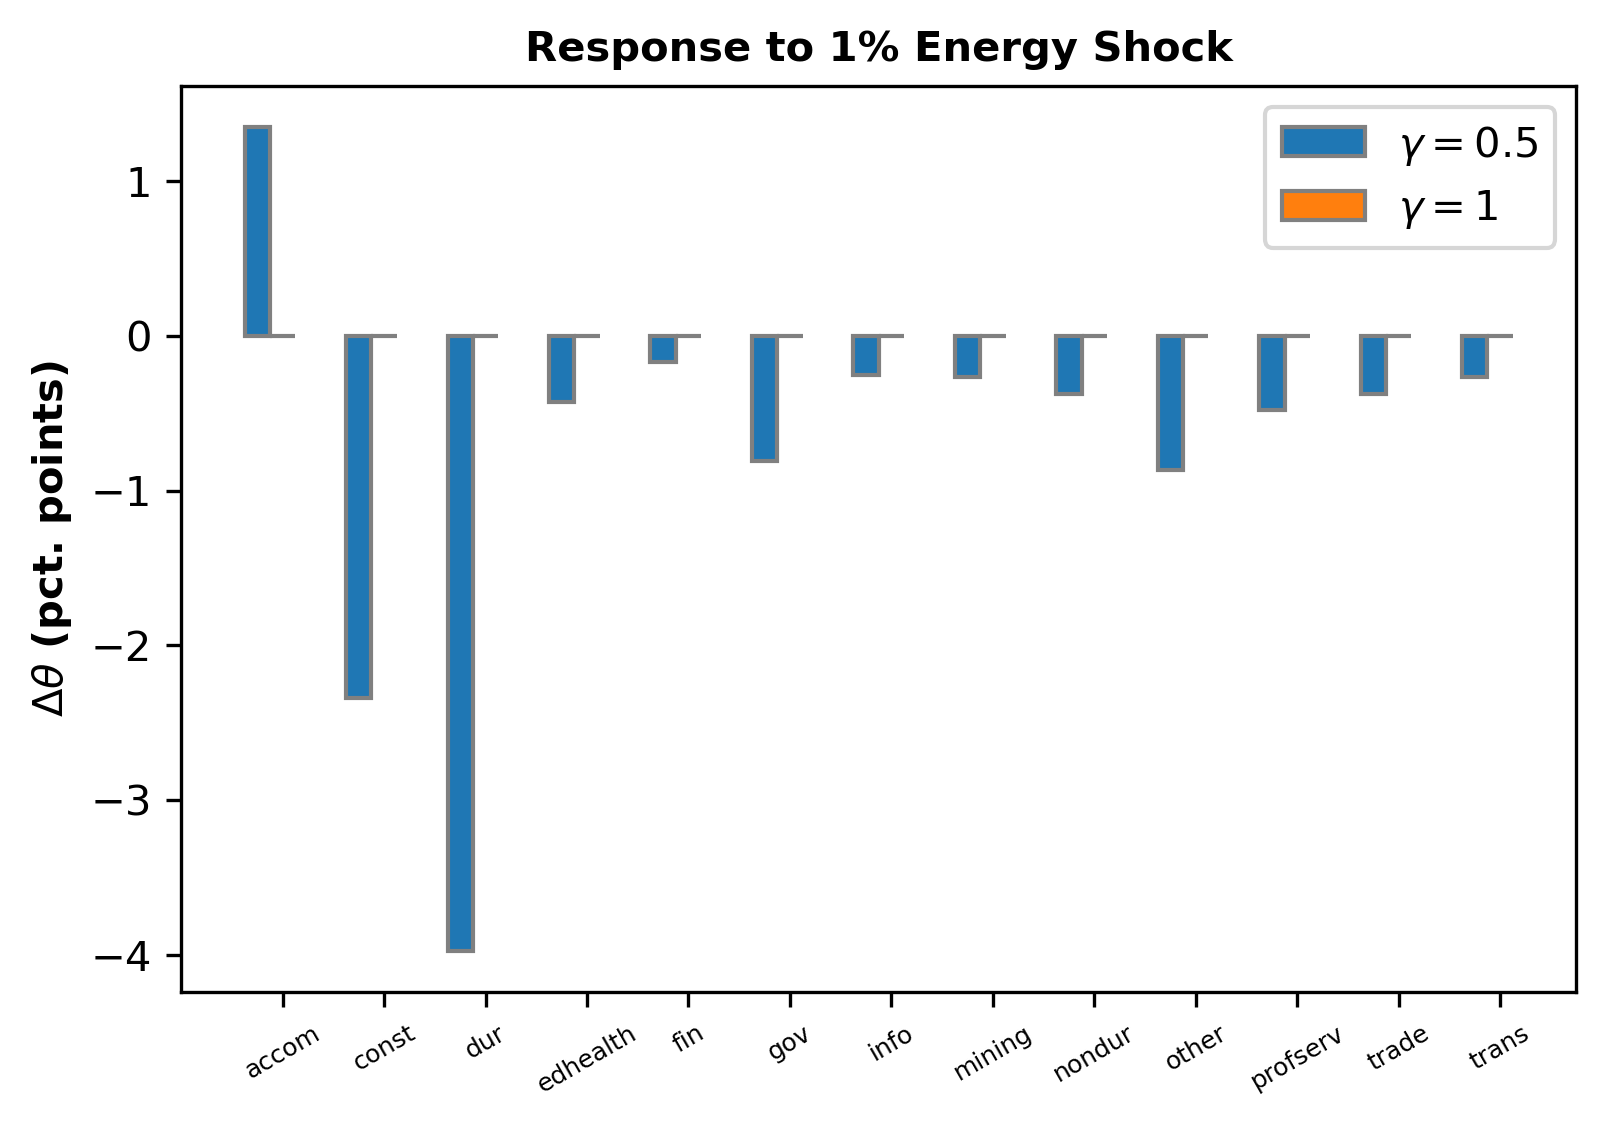

In [21]:
title = f'Response to 1% Energy Shock'
xlab = ''
ylab = '$\Delta \\theta$ (pct. points)'
save_path = f'../output/figures/A{A_spec}_EshockT_MP_calib2.png'
labels = ['$\gamma = 0.5$', '$\gamma = 1$']
bar_plot(100*occT_vec, occupation_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

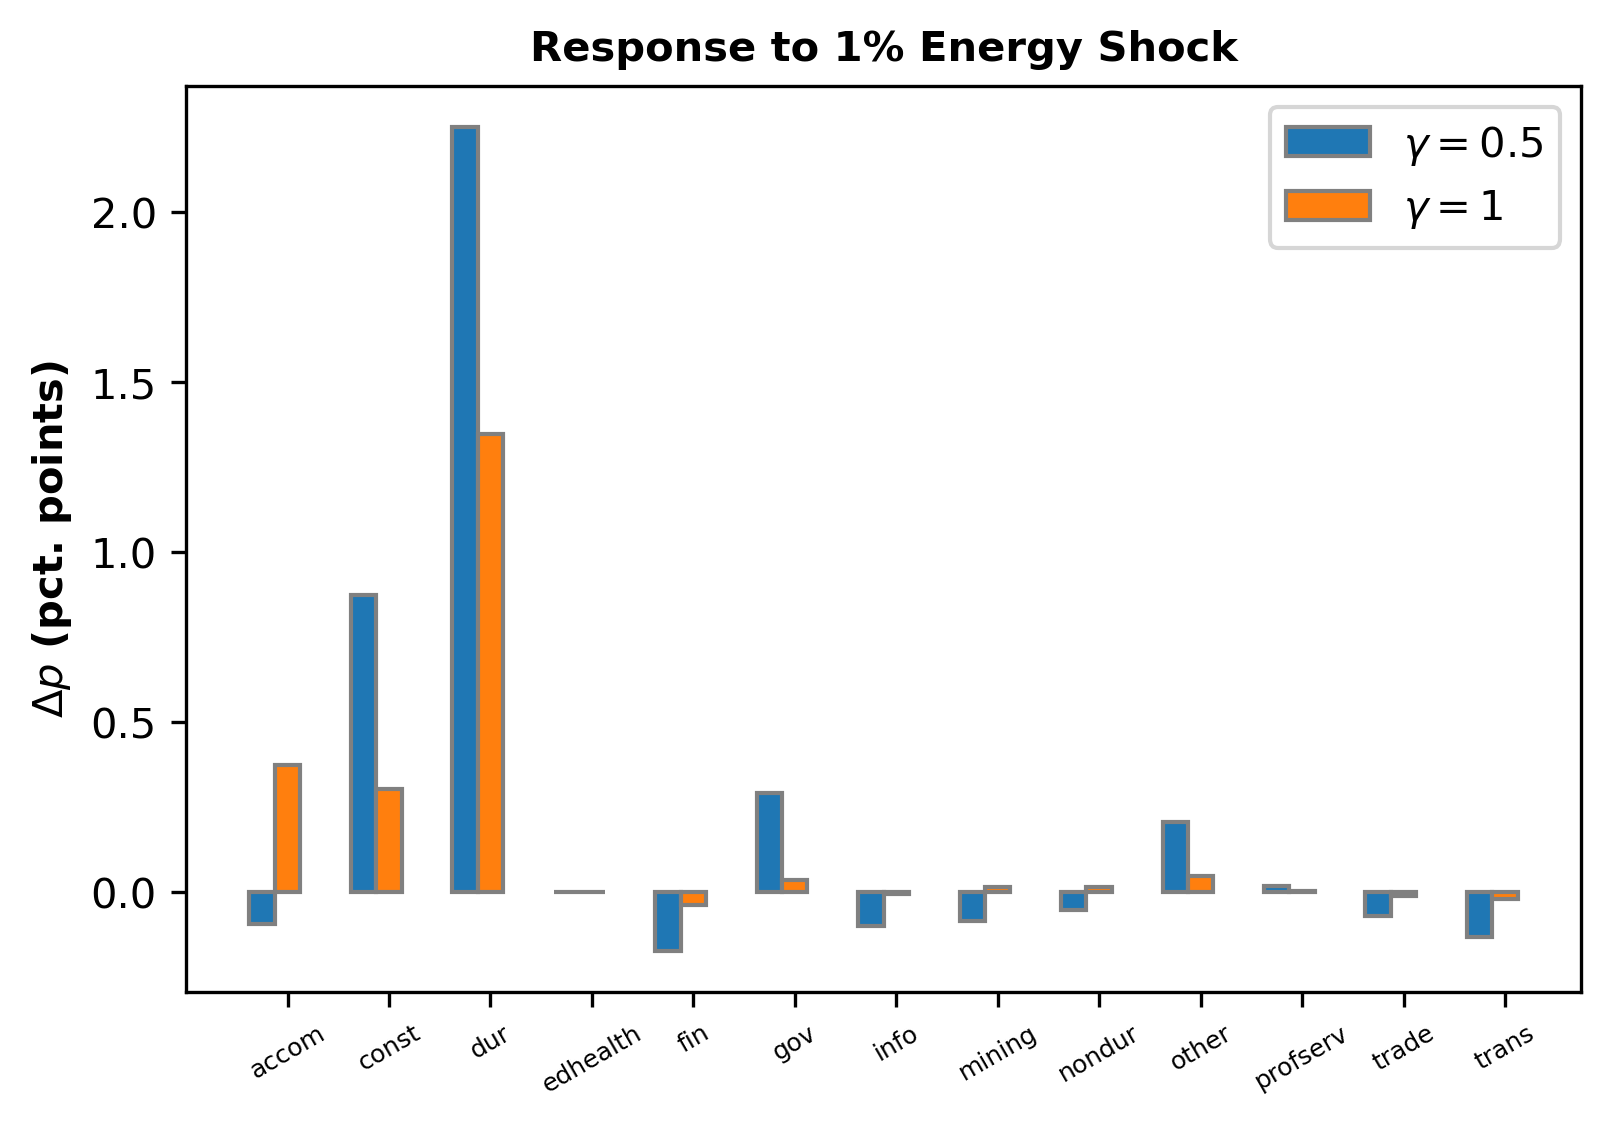

In [22]:
sector_names = list(dfA['short_names']) + ['Agg Y']
title = f'Response to 1% Energy Shock'
xlab = ''
ylab = '$\Delta p$ (pct. points)'
save_path = f'../output/figures/A{A_spec}_EshockP_MP_calib2.png'
labels = ['$\gamma = 0.5$', '$\gamma = 1$']
bar_plot(100*sectorP_vec, sectors, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

## Nominally rigid wages

What if instead of assuming wages respond proportionally to $\bm{\mathcal{L} \Psi}$ we assume that wages are nominally fully rigid. In this case, wage changes satisfy
\begin{align*}
    d\log \bm{w} - \bm{\mathcal{L}} d\log\bm{p} = - \bm{\mathcal{L}}d\log\bm{p}
\end{align*}
Where, up to a numeraire, $d\log\bm{p}$ satisfies 
\begin{align*}
    \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right)\bm{\mathcal{F}}\left(\bm{\Psi \varepsilon^f_N \mathcal{QT}}\right)^{-1} d\log\bm{p} = \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right) d\log\bm{H} - \left(\bm{I}-\bm{\mathcal{L}\Psi \varepsilon^f_N}\right)\bm{\mathcal{F}}\left(\bm{\Psi \varepsilon^f_N \mathcal{QT}}\right)^{-1}\bm{\Psi} d\log \bm{A}
\end{align*}
In principle, once we have picked a numeraire, we could write closed form expressions for $\Lambda_A$ and $\Lambda_H$ in terms of the parameters of the model. But these expressions will be complicated and doing so is unnecessary for the calibration. 

We can work out tightness now that we have wages.

We can now work out output.

In [23]:
num = 0
dlog_A = np.zeros((J, 1))
dlog_H = np.zeros((O,1))
dlog_K = np.zeros((K,1))
dlog_K[1] = -0.1 
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_A

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

We can work out tightness now that we have wages.

In [24]:
dlog_p = nominal_rigidity_network.PriceFuncAlt(dlog_A=dlog_A, dlog_H=dlog_H, dlog_K=dlog_K, Psi=Psi, epsN=epsN, epsK=epsK, curlyQ=curlyQ, curlyT=curlyT, curlyF=curlyF, curlyL=curlyL, num=num)
dlog_theta = nominal_rigidity_network.ThetaFuncAlt(dlog_H, dlog_A, dlog_K, dlog_p, Psi, epsN, epsK, curlyL, curlyQ, curlyT, curlyF, num=num)
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_K, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, epsK, curlyT, curlyE)
dlog_r = nominal_rigidity_network.rFunc(dlog_y, dlog_K, num)
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)

In [25]:
dlog_theta

matrix([[-0.01556297],
        [-0.01888517],
        [-0.01466334],
        [-0.01404134],
        [-0.01389733],
        [-0.01314976],
        [-0.01285346],
        [-0.01263307],
        [-0.01530464],
        [-0.01668651],
        [-0.01483915],
        [-0.01635241],
        [-0.01661781]])

In [26]:
dlog_y

matrix([[-0.00931971],
        [-0.00977805],
        [-0.0067516 ],
        [-0.00900945],
        [-0.0094773 ],
        [-0.00909036],
        [-0.00584719],
        [-0.00683631],
        [-0.00824025],
        [-0.00928816],
        [-0.0088712 ],
        [-0.0093944 ],
        [-0.01913186]])

We can now work out output.

In [27]:
dlog_r

matrix([[-0.00931971],
        [ 0.09068029]])

In [28]:
epsK.shape

(13, 2)

In [29]:
dlog_aggY

matrix([[-0.00879896]])